In [234]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.graph_objects as go
import helpers as h

 ### Load Data and Organize Data

In [312]:
orders_df = pd.read_csv('data/pbe-orders.csv')
replace_df = pd.read_csv('data/pbe-replacements.csv')
returns_df = pd.read_csv('data/pbe-returns.csv')

 ### Align Column Names for Ease of Appending/Joining

In [313]:
order_sku_df = orders_df[['amazon-order-id', 'sku']]
order_sku_df = order_sku_df.rename(columns={'amazon-order-id': 'order-id'})

replace_orders = replace_df[['sku', 'reason', 'original-amazon-order-id']]
replace_orders = replace_orders.rename(columns={'original-amazon-order-id': 'order-id', 'status': 'reason'})

returns_orders = returns_df[['sku','detailed-disposition', 'order-id']]
returns_orders = returns_orders.rename(columns={'detailed-disposition': 'reason'})

 ### Append Returns and Replacements

In [311]:
all_returns_replace = pd.DataFrame.append(returns_orders, replace_orders)

# Set return/replacement reason to lowercase for groupby
all_returns_replace['reason'] = all_returns_replace['reason'].str.lower()

 ### Join Orders DataFrame with Defects DataFrame

In [318]:
join_order_defect = pd.merge(order_sku_df, 
                  all_returns_replace, 
                  how='left', 
                  left_on=['sku', 'order-id'], 
                  right_on=['sku', 'order-id'])

'''
Replace NaN values in reason column with 'quality'
to indicate customer received product and it is working
as expected. NaN results from no return or replacement
being associated to order-id.

Also categorized 'wrong item' and 'sellable' as 'quality'
as there is no indication that the product did not work.
'customer_damaged' was replaced with 'defective' as batteries
should be able to withstand the majority of expected
customer behavior. The assumption is made they are not 
microwaving their batteries.
'''

join_order_defect = join_order_defect.fillna('quality')\
                                        .replace({'customer_damaged': 'defective',
                                                  'sellable': 'quality',
                                                  'wrong item': 'quality'})


# Set a column where 'defective' == 1 and 'quality' == 0

join_order_defect['defective_code'] = join_order_defect['reason'].replace({'defective': 1,
                                                                           'quality': 0})

# Groupby reason and convert to defective status to get totals of defective and quality product

order_status_counts = join_order_defect.groupby('reason')\
                            .count()\
                            .reset_index()\
                            .rename(columns={'order-id': 'order-count', 'reason': 'defective-status'})\
                            .drop('sku',axis=1)

defective_count = order_status_counts.iloc[0,1]
quality_count = order_status_counts.iloc[1,1]
total_orders = order_status_counts['order-count'].sum()
defective_prop = defective_count/total_orders
quality_prop = quality_count/total_orders

 ### Use plotly to visualize defective vs. quality

In [319]:
fig = px.bar(order_status_counts, x='defective-status', y='order-count')
fig.show()

 ### Group defective product by SKU and Visualize

In [316]:
order_status_count_by_product = join_order_defect.groupby('sku').sum()\
                                        .drop(['PB-SB','PB-SB2'])\
                                        .reset_index()\
                                        .rename(columns={'defective_code': 'defective_units'})\
                                        .replace({'PB-AA': 'AA',
                                                  'PB-AAA': 'AAA',
                                                  'PB-DBAT': 'D',
                                                  'PB-9VBAT': '9V'})
order_status_count_by_product

fig = px.bar(order_status_count_by_product, x='sku', y='defective_units')
fig.show()

### One-Tailed Hypothesis Test to Determine with 95% Confidence Battery Company Does Not Need to Investigate Manufacturer

 - In the early stages, the battery company's tolerance for defect is higher as they work out kinks with the manufacturer and battery design. They are consistently researching defective product to fix known issues, but in the early stages are willing to manage defects up to 5%, as which stage they would request a formal investigation into the manufacturer to determine whether or not the root cause of defect is a result of manufacturing practices as opposed to a design flaw.
 
 - The null hypthesis in this test would be that the defective rate for these batteries will fall at or below 5% as future orders come through based on the current sample of orders and customer returns/defects.

In [364]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Null Hypothesis: We would conduct a manufacturer investigation at defect rate higher than 5%. H0: defect rate <=5%

# get std_e for both, alt is real, null is 5%

n = 1256
p_null = 0.05
p_alt = 0.033

binomial_dist = stats.binom(n, p_null)
binom_mean = n * p_null
binom_var = n * p_null * (1-p_null)
normal_approx = stats.norm(binom_mean, np.sqrt(binom_var))

p_value = 1 - normal_approx.cdf(1256 * p_alt)

p_value

0.9971484011687601

/Users/ryankirkland/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



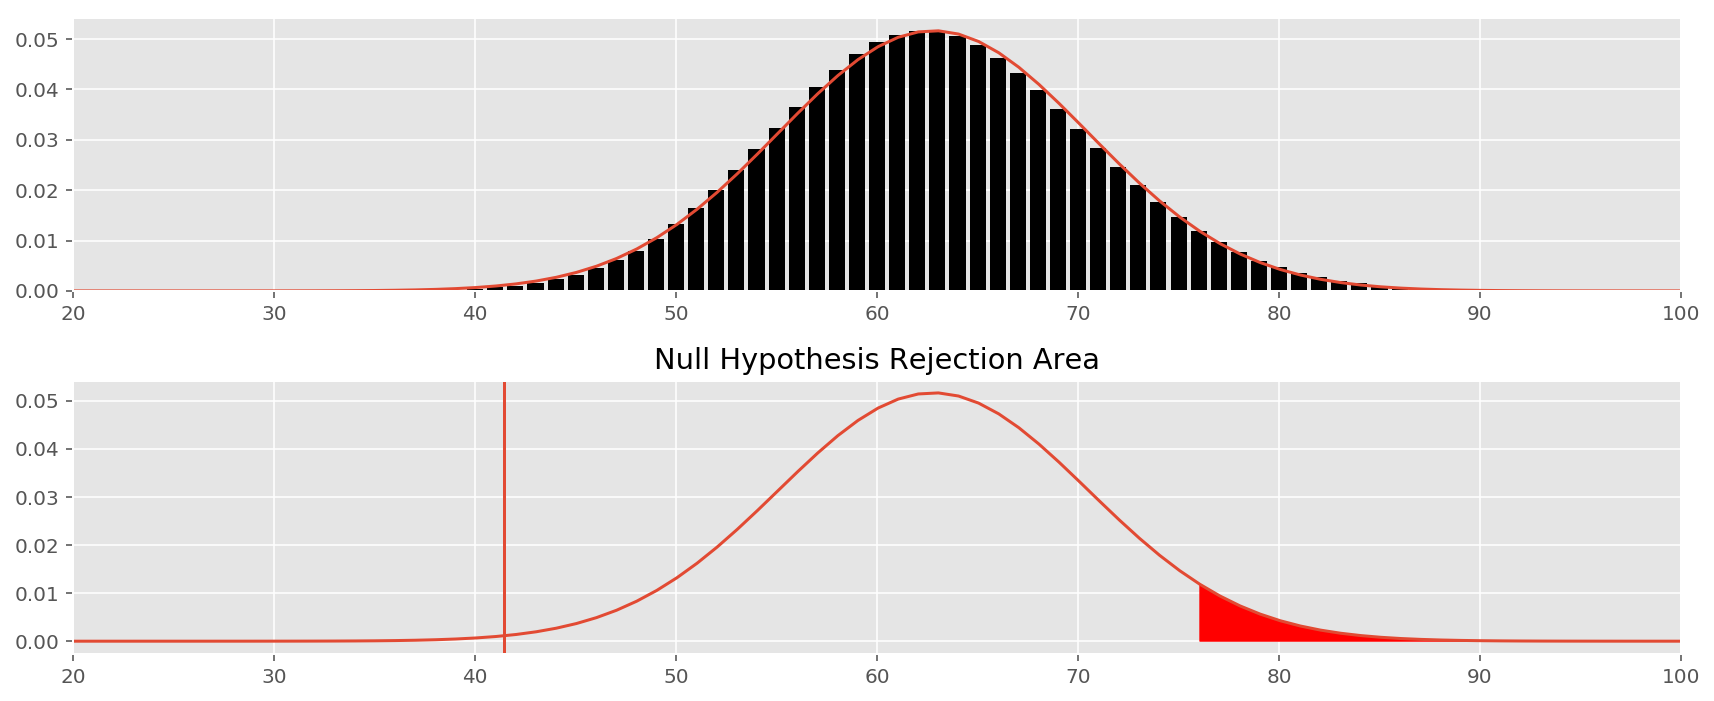

In [366]:
plt.style.use('ggplot')

x = np.linspace(0,1256, 1256)

fig, axs = plt.subplots(2, figsize = (12,5))
bar_sizes = [binomial_dist.pmf(i) for i in range(1257)]
bars = axs[0].bar(range(1257), bar_sizes, color="black", align="center")
axs[0].plot(x, normal_approx.pdf(x))
axs[0].set_xlim(20,100)

axs[1].set_title('Null Hypothesis Rejection Area')
axs[1].plot(x, normal_approx.pdf(x))
axs[1].fill_between(x, normal_approx.pdf(x), where=(x >= normal_approx.ppf(0.95)), color='red')
axs[1].set_xlim(20, 100)
axs[1].axvline(p_alt*1256)
fig.tight_layout()
fig.show()

In [131]:
orders_containing_multiple_skus = (orders_df['amazon-order-id'].duplicated().sum())

In [132]:
percent_orders_containing_mskus = (orders_df['amazon-order-id'].duplicated().sum())/len(orders_df['amazon-order-id'])

In [220]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

lower_state = {}

for k, v in us_state_abbrev.items():
    lower_state[k.lower()] = v
    lower_state[v.lower()] = v
    lower_state['n. j.'] = 'NJ'

orders_df['ship-state'] = orders_df['ship-state'].str.lower()
orders_df['ship-state-abbr'] = orders_df['ship-state'].map(lower_state)

In [221]:
state_df = grouped

In [136]:
state_df = state_df.reset_index().rename(columns={'ship-state-abbr': 'State', 'shipment-id': 'Orders Count'})

In [137]:
orders_by_state_df = state_df[['State', 'Orders Count']]

In [139]:
order_counts_by_state_dict = state_df.to_dict()

In [140]:
fig = go.Figure(data=go.Choropleth(
    locations=orders_by_state_df['State'], # Two-Letter State Codes
    z = orders_by_state_df['Orders Count'].astype(int), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Blues',
    colorbar_title = "Order Count",
))

fig.update_layout(
    title_text = 'Pale Blue Earth Order Quantities by State',
    geo_scope='usa', # limite map scope to USA
)

fig.write_html('/Users/ryankirkland/galvanize/capstones/capstone-one/state-heatmap.html')

fig.show()